In [1]:
from IPython.display import Image

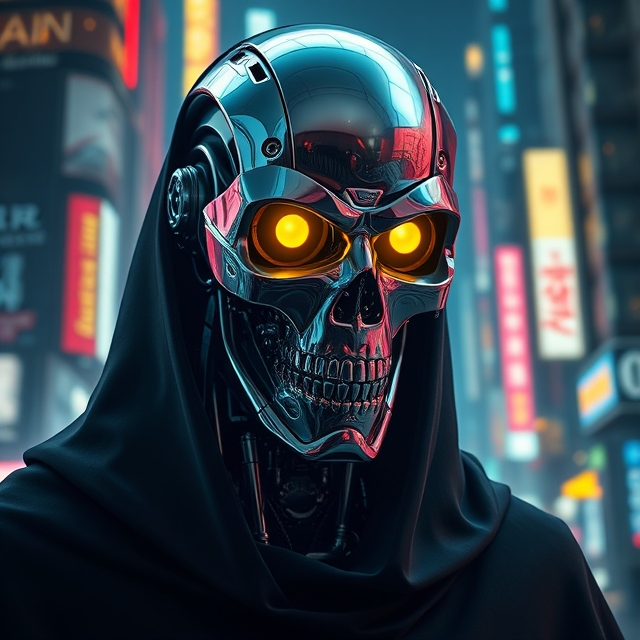

In [2]:
Image(filename = 'Simple-RAG-Agent.jpeg')

# Simple RAG Agent

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

Source: [LlamaIndex](https://docs.llamaindex.ai/en/stable/understanding/rag)

License: [Apache-2.0](https://github.com/mytechnotalent/Simple-RAG-Agent/blob/main/LICENSE)

## Introduction to RAG

LLMs are trained on enormous bodies of data but they aren't trained on your data. Retrieval-Augmented Generation (RAG) solves this problem by adding your data to the data LLMs already have access to. You will see references to RAG frequently in this documentation. Query engines, chat engines and agents often use RAG to complete their tasks.

In RAG, your data is loaded and prepared for queries or "indexed". User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.

Even if what you're building is a chatbot or an agent, you'll want to know RAG techniques for getting data into your application.

### Stages within RAG

There are five key stages within RAG, which in turn will be a part of most larger applications you build. These are:

* **Loading**: this refers to getting your data from where it lives -- whether it's text files, PDFs, another website, a database, or an API -- into your workflow. LlamaHub provides hundreds of connectors to choose from.
* **Indexing**: this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.
* **Storing**: once your data is indexed you will almost always want to store your index, as well as other metadata, to avoid having to re-index it.
* **Querying**: for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.
* **Evaluation**: a critical step in any flow is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.

### Important Concepts within RAG

There are also some terms you'll encounter that refer to steps within each of these stages.

**Loading Stage**
1. **Nodes and Documents**: A Document is a container around any data source - for instance, a PDF, an API output, or retrieve data from a database. A Node is the atomic unit of data in LlamaIndex and represents a "chunk" of a source Document. Nodes have metadata that relate them to the document they are in and to other nodes.
2. **Connectors**: A data connector (often called a Reader) ingests data from different data sources and data formats into Documents and Nodes.

**Indexing Stage**
1. **Indexes**: Once you've ingested your data, LlamaIndex will help you index the data into a structure that's easy to retrieve. This usually involves generating vector embeddings which are stored in a specialized database called a vector store. Indexes can also store a variety of metadata about your data.
2. **Embeddings**: LLMs generate numerical representations of data called embeddings. When filtering your data for relevance, LlamaIndex will convert queries into embeddings, and your vector store will find data that is numerically similar to the embedding of your query.

**Querying Stage**
1. **Retrievers**: A retriever defines how to efficiently retrieve relevant context from an index when given a query. Your retrieval strategy is key to the relevancy of the data retrieved and the efficiency with which it's done.
2. **Routers**: A router determines which retriever will be used to retrieve relevant context from the knowledge base. More specifically, the RouterRetriever class, is responsible for selecting one or multiple candidate retrievers to execute a query. They use a selector to choose the best option based on each candidate's metadata and the query.
3. **Node Postprocessors**: A node postprocessor takes in a set of retrieved nodes and applies transformations, filtering, or re-ranking logic to them.
4. **Response Synthesizers**: A response synthesizer generates a response from an LLM, using a user query and a given set of retrieved text chunks.

## Loading Data (Ingestion)

Before your chosen LLM can act on your data, you first need to process the data and load it. This has parallels to data cleaning/feature engineering pipelines in the ML world, or ETL pipelines in the traditional data setting.

This ingestion pipeline typically consists of three main stages:
1. Load the data
2. Transform the data
3. Index and store the data

### Loaders

Before your chosen LLM can act on your data you need to load it. The way LlamaIndex does this is via data connectors, also called `Reader`. Data connectors ingest data from different data sources and format the data into Document objects. A `Document` is a collection of data (currently text, and in future, images and audio) and metadata about that data.

#### Loading using `SimpleDirectoryReader`

The easiest reader to use is our `SimpleDirectoryReader`, which creates documents out of every file in a given directory. It is built in to LlamaIndex and can read a variety of formats including Markdown, PDFs, Word documents, PowerPoint decks, images, audio and video.

```python
documents = SimpleDirectoryReader("./data").load_data()
```

### Transformations

After the data is loaded, you then need to process and transform your data before putting it into a storage system. These transformations include chunking, extracting metadata, and embedding each chunk. This is necessary to make sure that the data can be retrieved, and used optimally by the LLM.

Transformation input/outputs are `Node` objects (a `Document` is a subclass of a `Node`). Transformations can also be stacked and reordered.

We have both a high-level and lower-level API for transforming documents.

#### High-Level Transformation API

Indexes have a `.from_documents()` method which accepts an array of Document objects and will correctly parse and chunk them up. However, sometimes you will want greater control over how your documents are split up.

```python
vector_index = VectorStoreIndex.from_documents(documents)
query_engine = vector_index.as_query_engine()
```

Under the hood, this splits your Document into Node objects, which are similar to Documents (they contain text and metadata) but have a relationship to their parent Document.

## Indexing

With your data loaded, you now have a list of Document objects (or a list of Nodes). It's time to build an Index over these objects so you can start querying them.

### What is an Index?

In LlamaIndex terms, an `Index` is a data structure composed of `Document` objects, designed to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy.

LlamaIndex offers several different index types. We'll cover the two most common here.

### Vector Store Index

A `VectorStoreIndex` is by far the most frequent type of Index you'll encounter. The Vector Store Index takes your Documents and splits them up into Nodes. It then creates `vector` embeddings of the text of every node, ready to be queried by an LLM.

#### What is an embedding?

A `vector embedding`, often just called an embedding, is a **numerical representation of the semantics, or meaning of your text**. Two pieces of text with similar meanings will have mathematically similar embeddings, even if the actual text is quite different.

This mathematical relationship enables **semantic search**, where a user provides query terms and LlamaIndex can locate text that is related to the **meaning of the query terms** rather than simple keyword matching. This is a big part of how Retrieval-Augmented Generation works, and how LLMs function in general.

There are many types of embeddings, and they vary in efficiency, effectiveness and computational cost. By default LlamaIndex uses `text-embedding-ada-002`, which is the default embedding used by OpenAI. If you are using different LLMs you will often want to use different embeddings.

#### Vector Store Index Embeds Your Documents

Vector Store Index turns all of your text into embeddings using an API from your LLM; this is what is meant when we say it "embeds your text". If you have a lot of text, generating embeddings can take a long time since it involves many round-trip API calls.

When you want to search your embeddings, your query is itself turned into a vector embedding, and then a mathematical operation is carried out by VectorStoreIndex to rank all the embeddings by how semantically similar they are to your query.

#### Top K Retrieval

Once the ranking is complete, VectorStoreIndex returns the most-similar embeddings as their corresponding chunks of text. The number of embeddings it returns is known as `k`, so the parameter controlling how many embeddings to return is known as `top_k`. This whole type of search is often referred to as "top-k semantic retrieval" for this reason.

Top-k retrieval is the simplest form of querying a vector index.

#### Using Vector Store Index

To use the Vector Store Index, pass it the list of Documents you created during the loading stage:
```python
index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)
```
With your text indexed, it is now technically ready for querying! However, embedding all your text can be time-consuming and, if you are using a hosted LLM, it can also be expensive. To save time and money you will want to store your embeddings first.

### Summary Index

A Summary Index is a simpler form of Index best suited to queries where, as the name suggests, you are trying to generate a summary of the text in your Documents. It simply stores all of the Documents and returns all of them to your query engine.

## Querying

Now you've loaded your data, built an index, you're ready to get to the most significant part of an LLM application: querying.

At its simplest, querying is just a prompt call to an LLM: it can be a question and get an answer, or a request for summarization, or a much more complex instruction.

More complex querying could involve repeated/chained prompt + LLM calls, or even a reasoning loop across multiple components.

### Getting Started

The basis of all querying is the QueryEngine. The simplest way to get a `QueryEngine` is to get your index to create one for you, like this:
```python
query_engine = index.as_query_engine()

response = query_engine.query(
    "What are the signs of Lung Cancer?"
)
print(response)
```

### Stages of Querying

However, there is more to querying than initially meets the eye. Querying consists of three distinct stages:

* **Retrieval** is when you find and return the most relevant documents for your query from your `Index`. As previously discussed in indexing, the most common type of retrieval is "top-k" semantic retrieval, but there are many other retrieval strategies.
* **Postprocessing** is when the Nodes retrieved are optionally reranked, transformed, or filtered, for instance by requiring that they have specific metadata such as keywords attached.
* **Response Synthesis** is when your query, your most-relevant data and your prompt are combined and sent to your LLM to return a response.

## Create Basic Tools

For this simple example we'll be creating two tools: one that calculates the factorial of a number and the other to check if a number is prime.

```python
def factorial(n: int) -> int:
    """Calculate the factorial of a number."""
    if n == 0:
        return 1
    return n * factorial(n - 1)


def is_prime(n: int) -> bool:
    """Check if a number is prime."""
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True
```

As you can see, these are regular vanilla Python functions. The docstring comments provide metadata to the agent about what the tool does: if your LLM is having trouble figuring out which tool to use, these docstrings are what you should tweak first.

After each function is defined we create `FunctionTool` objects from these functions, which wrap them in a way that the agent can understand.

```python
factorial_tool = FunctionTool.from_defaults(fn=factorial)
is_prime_tool = FunctionTool.from_defaults(fn=is_prime)
```

## Initialize the LLM

We will use the `mixtral:8x7b` open-source model with Ollama.

```python
llm = Ollama(model="mixtral:8x7b", request_timeout=300.0)
```

## Initialize the Agent

Now we create our agent. In this case, this is a `ReAct` agent, a relatively simple but powerful agent. We give it an array containing our two tools, the LLM we just created, and set `verbose=True` so we can see what's going on.

```python
agent = ReActAgent.from_tools(
    [
        factorial_tool, 
        is_prime_tool
    ], 
    llm=llm, 
    verbose=True, 
    max_iterations=10  # increase from the default (usually 3-5)
)
```

## Ask a Question

We specify that it should use a tool, as this is pretty simple and `mixtral:8x7b` doesn't really need this tool to get the answer.

```python
response = agent.chat("Lung cancer is the leading cause of cancer deaths worldwide. If a patient diagnosed with lung cancer has undergone 5 treatment cycles, what is the factorial of the number of cycles completed? Also, is the number of lung cancer stages (usually 4) a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.")
```

```python
response = agent.chat("Lung cancer treatments often involve a series of diagnostic tests to determine the most effective approach. If there are 6 diagnostic tests available and the oncologist wants to explore all possible ways to sequence them, what is the total number of permutations? Also, given that lung cancer affects approximately 1 in 14 people during their lifetime, is the number 14 a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.")
```

## Install Libraries

In [3]:
!pip install llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-embeddings-huggingface

## Install & Run Ollama

In [4]:
import os
import platform
import subprocess


def install_and_manage_ollama():
    """Install and manage Ollama on various OS platforms."""

    # detect system
    system = platform.system()

    try:
        # check if Ollama is installed
        if system == "Darwin":
            print("Detected macOS. Checking if Ollama is installed...")
            if subprocess.run(['which', 'ollama'], stdout=subprocess.PIPE, stderr=subprocess.PIPE).returncode != 0:
                print("Installing Ollama on macOS using Homebrew...")
                os.system("brew install ollama")
            else:
                print("Ollama is already installed.")
        elif system == "Linux":
            print("Detected Linux. Checking if Ollama is installed...")
            if subprocess.run(['which', 'ollama'], stdout=subprocess.PIPE, stderr=subprocess.PIPE).returncode != 0:
                print("Installing Ollama on Linux...")
                os.system("curl -sSL https://ollama.com/install | sh")
            else:
                print("Ollama is already installed.")
        elif system == "Windows":
            print("Detected Windows.")
            print("Please download and install Ollama manually from https://ollama.com.")
            return
        else:
            print("Unsupported operating system. Exiting.")
            return

        # start a new Ollama process if Mac or Linux
        print("Managing Ollama process...")
        if system in ["Darwin", "Linux"]:
            print("Starting ollama serve in the background...")
            subprocess.Popen(['ollama', 'serve'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, preexec_fn=os.setpgrp)
            print("ollama serve is now running in the background.")
        else:
            print("Automatic management of Ollama is not supported on Windows. Please run Ollama manually.")
    except Exception as e:
        print(f"An error occurred: {e}")
        return


# run the function
install_and_manage_ollama()

Detected macOS. Checking if Ollama is installed...
Ollama is already installed.
Managing Ollama process...
Starting ollama serve in the background...
ollama serve is now running in the background.


## Obtain `mixtral:8x7b` Model

In [5]:
import platform
import subprocess


def run_ollama_mixtral():
    """Obtain mixtral:8x7b model from Ollama."""

    # detect system
    system = platform.system()

    # detect and obtain mixtral:8x7b model on respective OS platform
    try:
        if system in ["Darwin", "Linux"]:  
            print(f"Detected {system}. Running ollama mixtral:8x7b...")
            if subprocess.run(['which', 'ollama'], stdout=subprocess.PIPE, stderr=subprocess.PIPE).returncode != 0:
                print("Ollama is not installed. Please install it and try again.")
                return
            result = subprocess.run(['ollama', 'run', 'mixtral:8x7b'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            if result.returncode == 0:
                print("Command executed successfully.")
            else:
                print("Failed to execute the command:")
                print(result.stderr)
        elif system == "Windows":
            print("Detected Windows.")
            print("Please run the following command manually in your terminal:")
            print("`ollama run mixtral:8x7b`")
            return
        else:
            print("Unsupported operating system. Exiting.")
            return
    except Exception as e:
        print(f"An error occurred: {e}")
        return


# run the function
run_ollama_mixtral()

Detected Darwin. Running ollama mixtral:8x7b...
Command executed successfully.


## Imports

In [6]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.ollama import Ollama

## Declare LLM `mixtral:8x7b`

In [7]:
llm = Ollama(model="mixtral:8x7b", request_timeout=360.0)

## Declare Embedding Model

In [8]:
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

## Set Global Settings for the LLM and Embedding Model

In [9]:
Settings.llm = llm
Settings.embed_model = embed_model

## Read Documents

In [10]:
documents = SimpleDirectoryReader("./data").load_data()
index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)
query_engine = index.as_query_engine()

## Initial Query Documents

In [11]:
response = query_engine.query(
    "What are the signs of Lung Cancer?"
)
print(response)

 The signs of lung cancer include cough, hemoptysis, dyspnea, chest pain, recurrent or slowly resolving pneumonia, lethargy, anorexia, and weight loss. Additionally, a person with lung cancer may experience cachexia, anemia, clubbing, hypertrophic pulmonary osteoarthropathy (HPOA), supraclavicular or axillary nodes, and chest signs such as none, consolidation, collapse, pleural effusion. Metastases can also occur, leading to bone tenderness, hepatomegaly, confusion, seizures, focal CNS signs, cerebellar syndrome, proximal myopathy, and peripheral neuropathy.


## Instantiate LLM, Register Tools w/ `ReactAgent`, Instantiate `agent` Object

In [12]:
from llama_index.core.agent import ReActAgent
from llama_index.llms.ollama import Ollama
from llama_index.core.tools import FunctionTool


def factorial(n: int) -> int:
    """Calculate the factorial of a number."""

    if n == 0:
        return 1
    return n * factorial(n - 1)


def is_prime(n: int) -> bool:
    """Check if a number is prime."""

    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True


factorial_tool = FunctionTool.from_defaults(fn=factorial)
is_prime_tool = FunctionTool.from_defaults(fn=is_prime)

llm = Ollama(model="mixtral:8x7b", request_timeout=300.0)

agent = ReActAgent.from_tools(
    [
        factorial_tool, 
        is_prime_tool
    ], 
    llm=llm, 
    verbose=True, 
    max_iterations=10  # increase from the default (usually 3-5)
)

## Chat w/ RAG Agent

In [13]:
response = agent.chat("Lung cancer is the leading cause of cancer deaths worldwide. If a patient diagnosed with lung cancer has undergone 5 treatment cycles, what is the factorial of the number of cycles completed? Also, is the number of lung cancer stages (usually 4) a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.")
print(response)

> Running step 0c690c36-173f-43dd-8a49-b05489065f45. Step input: Lung cancer is the leading cause of cancer deaths worldwide. If a patient diagnosed with lung cancer has undergone 5 treatment cycles, what is the factorial of the number of cycles completed? Also, is the number of lung cancer stages (usually 4) a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.
Thought: The user has asked for two pieces of information. First, they want to know the factorial of the number of lung cancer treatment cycles a patient has undergone, which is 5. Second, they want to know if the number of lung cancer stages (usually 4) is a prime number. I will use the 'factorial' tool to find the factorial of 5 and the 'is_prime' tool to check if 4 is a prime number.
Action: factorial
Action Input: {'n': 5}
Observation: 120
> Running step a6682c95-2f43-4793-b8a6-a3c69b119459. Step input: None
Thought: The 'factorial' tool has returned 120, whic

In [14]:
response = agent.chat("Lung cancer treatments often involve a series of diagnostic tests to determine the most effective approach. If there are 6 diagnostic tests available and the oncologist wants to explore all possible ways to sequence them, what is the total number of permutations? Also, given that lung cancer affects approximately 1 in 14 people during their lifetime, is the number 14 a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.")
print(response)

> Running step cf5f43cf-dfd9-43ca-896a-b2908df0affb. Step input: Lung cancer treatments often involve a series of diagnostic tests to determine the most effective approach. If there are 6 diagnostic tests available and the oncologist wants to explore all possible ways to sequence them, what is the total number of permutations? Also, given that lung cancer affects approximately 1 in 14 people during their lifetime, is the number 14 a prime number? Calculate step by step detailing all of your thought process and make sure you use the tools provided.
Thought: I need to find the factorial of a number using the tool 'factorial'.
Action: factorial
Action Input: {'n': 6}
Observation: 720
> Running step 1f0d52c1-0177-445a-bd70-4767ff74218b. Step input: None
Thought: The total number of permutations for sequencing 6 diagnostic tests is 720. Now, I need to determine if the number 14 is prime using the tool 'is_prime'.
Action: is\_prime
Action Input: {'n': 14}
Observation: Error: No such tool nam

## Terminate Ollama Instances

In [15]:
import os
import platform
import subprocess
import time


def kill_existing_ollama():
    """Kill all existing Ollama processes on macOS or Linux."""

    # detect system
    system = platform.system()

    # handle Windows OS
    if system not in ["Darwin", "Linux"]:
        print("This script is designed to run on macOS or Linux. Skipping process termination.")
        return

    # terminate all Ollama instances
    result = subprocess.run(['pgrep', '-f', 'ollama'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.stdout:
        pids = result.stdout.strip().splitlines()  # get all PIDs
        print(f"Found running Ollama processes with PIDs: {', '.join(pids)}. Killing them...")
        for pid in pids:
            try:
                os.kill(int(pid), 9)  # kill each PID individually
                print(f"Killed process with PID: {pid}")
            except Exception as e:
                print(f"Failed to kill process with PID: {pid}. Error: {e}")
        print("Waiting for processes to terminate...")
        time.sleep(10)  # allow time for processes to shut down
    else:
        print("No Ollama process found running.")


# run the function
kill_existing_ollama()

Found running Ollama processes with PIDs: 94849, 95452. Killing them...
Killed process with PID: 94849
Killed process with PID: 95452
Waiting for processes to terminate...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
